# Calibración de un sensor de bajo costo 

Se busca calibrar un sensor de material particulado de 2.5 $\mu m$, tomando como referencia las mediaciones de las estaciones **AMB**

In [1]:
# Librerias 
import pandas as pd #Manejo de datos
import numpy as np #Manejo de datos y matematica 
import matplotlib.pyplot as plt #Graficas
from datetime import datetime, timedelta #Tiempo
from scipy.optimize import curve_fit #Hacer ajuste por minimos cuadrados

## Los datos
Los datos se encuentran en formato **cvs** y **xslx**

Los datos corresponden a los tomados entre el **2018-10** y **2019-8**


### AMB
De los datos de la **AMB** solo utilizamos los correspondientes a la estación de la  **Escuela normal superior**, que es la más cercana a ubicación del **sensor**

* El formato de la columna **Date&Time** se modifico previamente a un formato de **Fecha y hora**


In [2]:
# Cargar los datos especificamente de la hoja "Normal"
data_AMB = pd.read_excel("Datos Estaciones AMB.xlsx",sheet_name='Normal', header= 0)
data_AMB = data_AMB[1:] #removi la fila 1 (la de las unidades)
data_AMB[10:20]   #muestro las 5 primeras filas

,Date&Time,PM10,PM2.5,Temp_Aire,Lluvia,Humedad_relativa,WD,WS,R_Solar
11,2018-10-01 10:00:00,34.2,13.6,27.3,0,50.8,222.8,1.3,888.6
12,2018-10-01 11:00:00,21.4,9,28.2,0,48.4,250.9,1.4,891.5
13,2018-10-01 12:00:00,18,7.8,28.3,0,52.1,255.7,1.5,735.5
14,2018-10-01 13:00:00,20.1,7.3,27.2,0,60.5,270.6,1.2,415.6
15,2018-10-01 14:00:00,20.2,8.4,27.2,0,60.7,231.1,1.2,649.3
16,2018-10-01 15:00:00,18,8.2,27.3,0,61,272,1,256.8
17,2018-10-01 16:00:00,18.6,7.7,26.3,0,66.5,297.5,1.7,143.3
18,2018-10-01 17:00:00,23.5,8.1,25.3,0,74,288.9,1.7,25.1
19,2018-10-01 18:00:00,21.1,8.6,24.7,0,76.8,312.2,1.7,0
20,2018-10-01 19:00:00,17.7,7.2,24.4,0,78.8,328.2,2.4,0


### Sensor

De los datos del sensor en algunos no se registraron mediciones
* 2018-10 ------> **Sin datos**
* 2018-11 ------> Con datos
* 2018-12 ------> Con datos
* 2019-01 ------> **Sin datos**
* 2019-02 ------> **Sin datos**
* 2019-03 ------> **Sin datos**
* 2019-04 ------> Con datos
* 2019-05 ------> Con datos
* 2019-06 ------> Con datos
* 2019-07 ------> Con datos
* 2019-08 ------> Con datos

En base a lo anterior se separan en dos conjuntos de datos **2018-11 - 2018-12** y  **2019-4 - 2019-8**

### 2018-11 - 2018-12

Al verificar la frecuencia de muestreo del sensor en este periodo se evidencia que cambia de tomar varias mediciones por a una frecuencia de muestreo de un dato por hora

In [3]:
# Crear dos archivos con los bloques de datos que tengo uno 2018-11 a 2018-12
data_2018_dic = {}  #un diccionario
columnas = ['time','variable', 'PM2.5']
data_2018_dic['2018-11'] = pd.read_csv("mediciones_clg_normalsup_pm25_a_2018-11-01T00_00_00_2018-11-30T23_59_59.csv", sep= ",", decimal=".", names = columnas, skiprows = 1) 
data_2018_dic['2018-12'] = pd.read_csv("mediciones_clg_normalsup_pm25_a_2018-12-01T00_00_00_2018-12-31T23_59_59.csv", sep= ",", decimal=".", names = columnas, skiprows = 1)

data_2018 = {}
data_2018["time"] = []
data_2018["PM2.5"] = []
for i in data_2018_dic:
    data_2018["time"].append(np.array(data_2018_dic[i]["time"][::-1]))
    data_2018["PM2.5"].append(np.array(data_2018_dic[i]["PM2.5"][::-1]))
    
    
data_2018['time'] = np.hstack(data_2018['time'])
data_2018['time'] = [datetime.strptime(i[:13],"%Y-%m-%dT%H")+ timedelta(hours=-5)  for i in data_2018['time']]
data_2018['PM2.5'] = np.hstack(data_2018['PM2.5'])


In [4]:
data_2018 = pd.DataFrame(data_2018)
data_2018[:3]

,time,PM2.5
0,2018-11-03 18:00:00,9.083333
1,2018-11-03 18:00:00,9.083333
2,2018-11-03 18:00:00,8.583334


Para solucionar la frecuencia de muestro, tomamos un promedio de los valores en las horas que se repiten

In [5]:
# Crear dos archivos del conjunto de daatos  de 2019-4 a 2019-8
data_2019_dic = {}  #un diccionario
columnas = ['time','variable', 'PM2.5']
data_2019_dic['2019-04'] = pd.read_csv("mediciones_clg_normalsup_pm25_a_2019-04-01T00_00_00_2019-04-30T23_59_59.csv", sep= ",", decimal=".", names = columnas, skiprows = 1) 
data_2019_dic['2019-05'] = pd.read_csv("mediciones_clg_normalsup_pm25_a_2019-05-01T00_00_00_2019-05-31T23_59_59.csv", sep= ",", decimal=".", names = columnas, skiprows = 1) 
data_2019_dic['2019-06'] = pd.read_csv("mediciones_clg_normalsup_pm25_a_2019-06-01T00_00_00_2019-06-30T23_59_59.csv", sep= ",", decimal=".", names = columnas, skiprows = 1) 
data_2019_dic['2019-07'] = pd.read_csv("mediciones_clg_normalsup_pm25_a_2019-07-01T00_00_00_2019-07-31T23_59_59.csv", sep= ",", decimal=".", names = columnas, skiprows = 1) 
data_2019_dic['2019-08'] = pd.read_csv("mediciones_clg_normalsup_pm25_a_2019-08-01T00_00_00_2019-08-31T23_59_59.csv", sep= ",", decimal=".", names = columnas, skiprows = 1) 

data_2019 = {}
data_2019["time"] = []
data_2019["PM2.5"] = []
for i in data_2019_dic:
    data_2019["time"].append(np.array(data_2019_dic[i]["time"][::-1]))
    #print(np.array(data_2019_dic[i]["time"][::-1]))
    data_2019["PM2.5"].append(np.array(data_2019_dic[i]["PM2.5"][::-1]))
    
data_2019['time'] = np.hstack(data_2019['time'])
data_2019['time'] = [datetime.strptime(i[:13],"%Y-%m-%dT%H")+ timedelta(hours=-5)  for i in data_2019['time']]
data_2019['PM2.5'] = np.hstack(data_2019['PM2.5'])

data_2019 = pd.DataFrame(data_2019)
data_2019[:3]

,time,PM2.5
0,2019-04-11 12:00:00,23.500000
1,2019-04-11 13:00:00,22.083334
2,2019-04-11 14:00:00,25.250000


Como los datos de la **AMB** contienen **str** hacemos un filtro para estos convirtiendolos en **Nan**

In [6]:
for i in range(1,len(data_AMB["PM2.5"])):
    if type(data_AMB["PM2.5"][i]) == str:
        data_AMB["PM2.5"][i] = "Nan"
    else: 
        data_AMB["PM2.5"][i] = data_AMB["PM2.5"][i]

## Visualizar los datos
Visualizamos los datos de AMB y el sensor

### Datos AMB

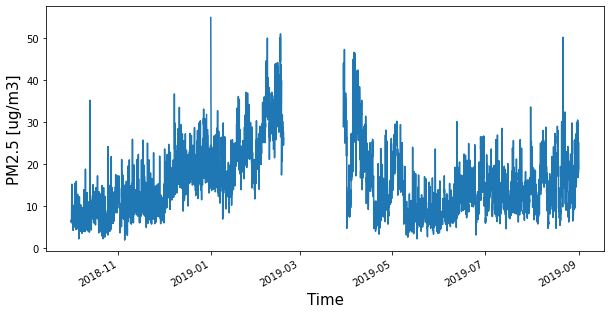

In [7]:
plt.figure(figsize=(10,5))
plt.ylabel('PM2.5 [ug/m3]', fontsize = 15)
plt.xlabel('Time', fontsize = 15)
plt.gcf().autofmt_xdate()
plt.plot(data_AMB["Date&Time"], data_AMB["PM2.5"])
plt.show()

### Sensor

#### 2018

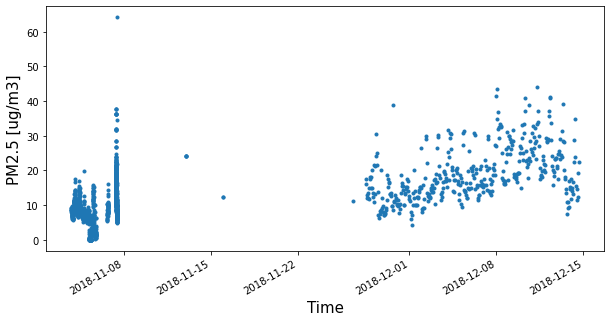

In [8]:
plt.figure(figsize=(10,5))
plt.ylabel('PM2.5 [ug/m3]', fontsize = 15)
plt.xlabel('Time', fontsize = 15)
plt.gcf().autofmt_xdate()
plt.plot(data_2018["time"], data_2018["PM2.5"],'.')
plt.show()

Como se puede ver en la gráfica anterior hay un periodo donde no se registraron mediciones,por tanto este conjunto de datos no es suficiente para establecer un modelo

#### 2019

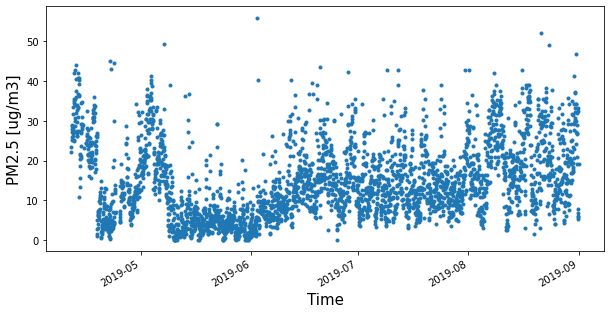

In [9]:
plt.figure(figsize=(10,5))
plt.ylabel('PM2.5 [ug/m3]', fontsize = 15)
plt.xlabel('Time', fontsize = 15)
plt.gcf().autofmt_xdate()
plt.plot(data_2019["time"], data_2019["PM2.5"], '.')
plt.show()

Como se muestran en las grafícas, el periodo donde tenemos datos de ambas estaciones es **2019-4 a 2019-8**, este será el que usa para establecer el modelo

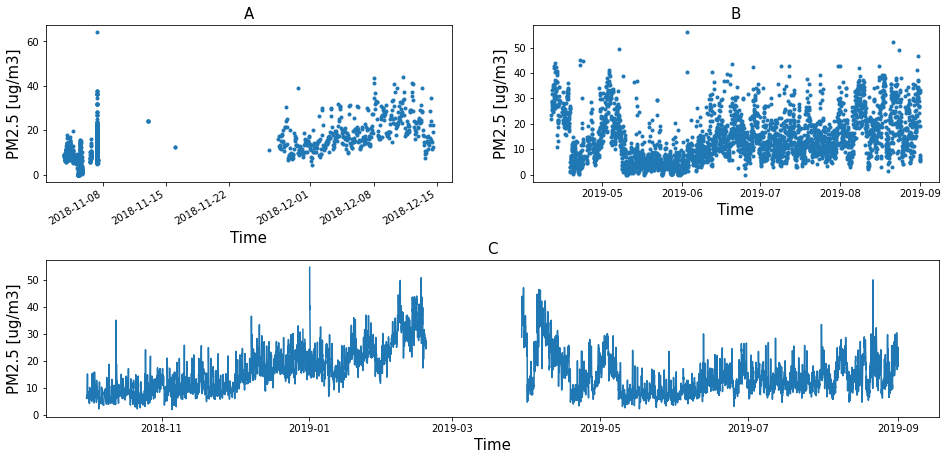

In [10]:
plt.figure(figsize=(16,8))
plt.subplots_adjust(hspace=0.5)

plt.subplot(221)
plt.title("A",fontsize = 15)
plt.ylabel('PM2.5 [ug/m3]', fontsize = 15)
plt.xlabel('Time', fontsize = 15)
plt.gcf().autofmt_xdate()
plt.plot(data_2018["time"], data_2018["PM2.5"],'.')


plt.subplot(222)
plt.title("B",fontsize = 15)
plt.ylabel('PM2.5 [ug/m3]', fontsize = 15)
plt.xlabel('Time', fontsize = 15)
#plt.gcf().autofmt_xdate()
plt.plot(data_2019["time"], data_2019["PM2.5"], '.')


plt.subplot(212)
plt.title("C",fontsize = 15)
plt.ylabel('PM2.5 [ug/m3]', fontsize = 15)
plt.xlabel('Time', fontsize = 15)
plt.plot(data_AMB["Date&Time"], data_AMB["PM2.5"])

plt.savefig('a', format='png', dpi=100,transparent=False)
plt.show()

In [11]:
# Quito los datos duplicados
data_2019 = data_2019.drop_duplicates()
data_2019 = data_2019.reset_index()

In [12]:
data = pd.DataFrame(columns=['time', 'AMB', "sensor"])

In [13]:
#Función para cambiar el formato de la hora 
def FormatoFechaHora (time):
    obj = datetime.strptime(time, "%Y-%m-%d %H:%M:%S")
    time_f2 = obj.strftime("%Y-%m-%d %H:%M:00")
    return time_f2

m = []
for i in range(1,len(data_AMB["Date&Time"])):
    m.append(FormatoFechaHora(str(data_AMB["Date&Time"][i])))
    
data_AMB["Date&Time"][1:] = m

In [14]:
time = []
AMB = []
sensor = []
for i in range(1,len(data_2019["time"])-1):
    estampa_t = str(data_2019["time"][i])
    time.append(data_2019["time"][i])
    indice_AMB = int(np.where(data_AMB["Date&Time"] == estampa_t)[0])
    indice_sensor = int(np.where(data_2019["time"] == estampa_t)[0])
    #print(indice_sensor)
    AMB.append(data_AMB["PM2.5"][indice_AMB])
    sensor.append(data_2019["PM2.5"][indice_sensor])


In [15]:
data["time"] = time 
data["AMB"] = AMB 
data["sensor"] = sensor
data[:3]

,time,AMB,sensor
0,2019-04-11 13:00:00,16.7,22.083334
1,2019-04-11 14:00:00,17.2,25.250000
2,2019-04-11 15:00:00,17.6,28.749998


### Visualizar los datos nuevamente

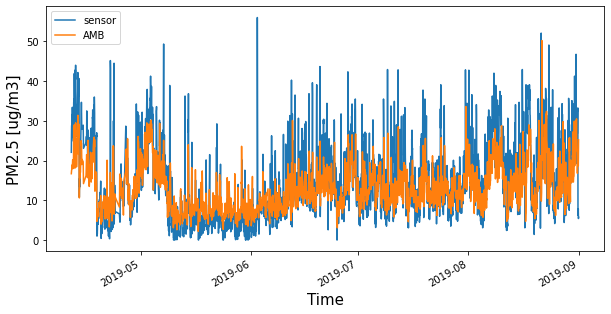

In [16]:
plt.figure(figsize=(10,5))
plt.ylabel('PM2.5 [ug/m3]', fontsize = 15)
plt.xlabel('Time', fontsize = 15)
plt.gcf().autofmt_xdate()
plt.plot(data["time"], data["sensor"], label = "sensor")
plt.plot(data["time"], data["AMB"], label = "AMB")
plt.legend()

plt.show()

In [17]:
def MediaMovil(Data,time, ventana):
    MM = []
    for i in range(0,len(Data)):
        if i < ventana:
            MM.append(Data[i])
        else:
            MM.append( np.mean(Data[i-ventana:i])  )
    return  np.array(MM)

In [18]:
dataa = data.copy(deep=True)
#dataa["sensor"]
type(data["AMB"][:1])

pandas.core.series.Series

In [19]:
n = 36
data["AMB"] = MediaMovil(data["AMB"],data["time"],n)
data["sensor"] =MediaMovil(data["sensor"],data["time"],n)
print ("Vebtana =", n)

Vebtana = 36


El ancho de la ventana  debe ser muy pequeño en comparación con la cantidad de datos para no afectar el comportamiento de estos (evitar perder información) y no tan pequeña por 

In [20]:
data = data[n:]
dataa = dataa[n:]

### AMB

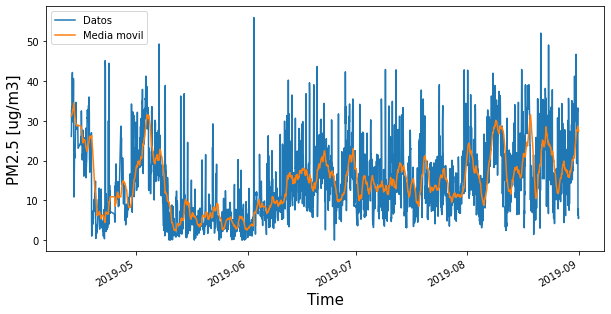

In [21]:
plt.figure(figsize=(10,5))
plt.ylabel('PM2.5 [ug/m3]', fontsize = 15)
plt.xlabel('Time', fontsize = 15)
plt.gcf().autofmt_xdate()
plt.plot(dataa["time"], dataa["sensor"],label = "Datos")
plt.plot(data["time"], data["sensor"],label = "Media movil")
plt.legend()

plt.show()

### Sensor

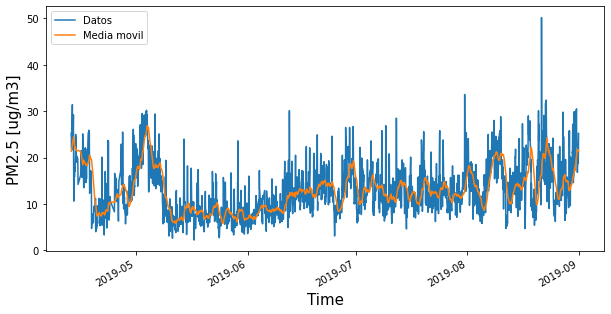

In [22]:
plt.figure(figsize=(10,5))
plt.ylabel('PM2.5 [ug/m3]', fontsize = 15)
plt.xlabel('Time', fontsize = 15)
plt.gcf().autofmt_xdate()
plt.plot(dataa["time"], dataa["AMB"],label = "Datos")
plt.plot(data["time"], data["AMB"],label = "Media movil")
plt.legend()

plt.show()

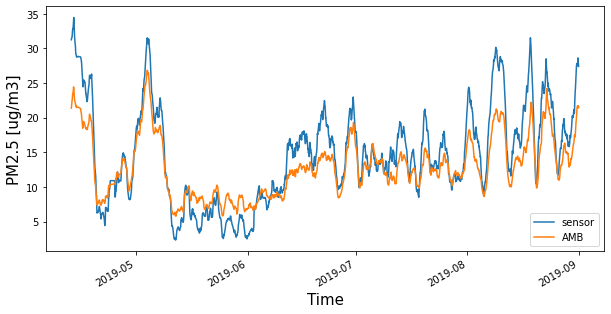

In [23]:
plt.figure(figsize=(10,5))
plt.ylabel('PM2.5 [ug/m3]', fontsize = 15)
plt.xlabel('Time', fontsize = 15)
plt.gcf().autofmt_xdate()
plt.plot(data["time"], data["sensor"], label = "sensor")
plt.plot(data["time"], data["AMB"], label = "AMB")
plt.legend()

plt.show()

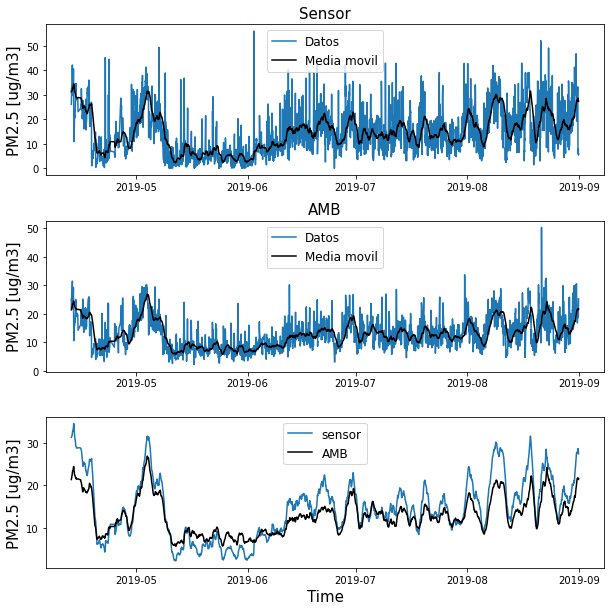

In [24]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.3)

plt.subplot(3, 1, 1)
plt.title("Sensor", fontsize = 15)
plt.plot(dataa["time"], dataa["sensor"],label = "Datos" )
plt.plot(data["time"], data["sensor"],label = "Media movil",  color = "k")
plt.ylabel('PM2.5 [ug/m3]', fontsize = 15)
plt.legend(loc=9, fontsize = 12)

plt.subplot(3, 1, 2)
plt.title("AMB", fontsize = 15)
plt.plot(dataa["time"], dataa["AMB"],label = "Datos")
plt.plot(data["time"], data["AMB"],label = "Media movil", color = "k")
plt.ylabel('PM2.5 [ug/m3]', fontsize = 15)
plt.legend(loc=9, fontsize = 12)


plt.subplot(3, 1, 3)
plt.plot(data["time"], data["sensor"], label = "sensor")
plt.plot(data["time"], data["AMB"], label = "AMB", color = "k")
plt.ylabel('PM2.5 [ug/m3]', fontsize = 15)
plt.xlabel('Time', fontsize = 15)
plt.legend(loc=9, fontsize = 12)

### Por fin puedo calcular la medida de distancia euclidiana

$$D = \sqrt{\sum (Dj - Di)^2}$$

In [25]:
D_euclidia = np.sqrt(np.sum((data["AMB"] - data["sensor"]) ** 2))
D_euclidia

198.01049504354614

ventana:
* 12 ---> 232.5837375551265
* 24 ---> 208.34049748050919
* 36 ---> 198.01049504354614
* 48 ---> 196.79163835982368 --->  **x**
* 72 ---> 179.56062595303527 --->  **x**

### Graficamos los datos para buscar una correlación (lineal)

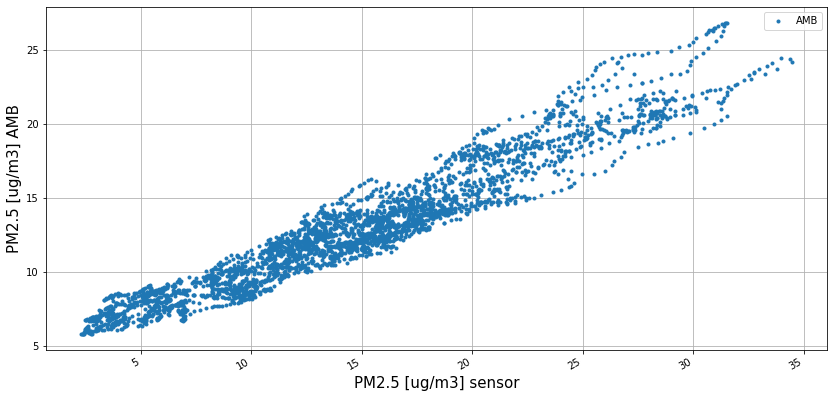

In [26]:
plt.figure(figsize=(14,7))
plt.ylabel('PM2.5 [ug/m3] AMB', fontsize = 15)
plt.xlabel('PM2.5 [ug/m3] sensor', fontsize = 15)
plt.plot(data["sensor"],data["AMB"], '.', label = "AMB")
plt.legend()
plt.gcf().autofmt_xdate()

plt.grid()

plt.show()

In [27]:
def modelo(x,a,b):
    return a * x + b

popt, pcov = curve_fit(modelo,data["sensor"],data["AMB"])
#popt, pcov = curve_fit(modelo,data_final["AMB"],data_final["sensor"])
popt[0], popt[1]

(0.5953953281639756, 4.221106165169793)

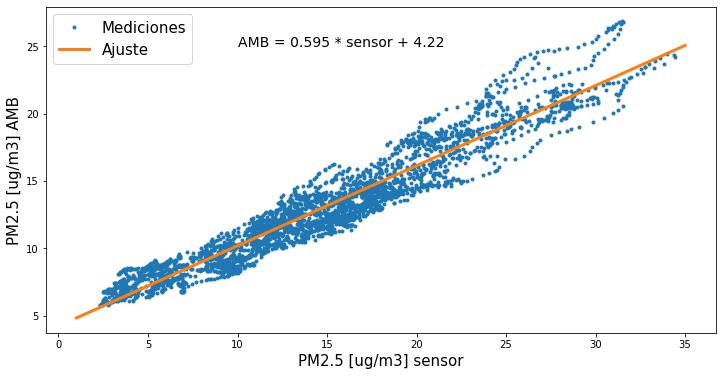

In [28]:
x = np.linspace(1,35,len(data["sensor"]))
plt.figure(figsize=(12,6))
plt.ylabel('PM2.5 [ug/m3] AMB', fontsize = 15)
plt.xlabel('PM2.5 [ug/m3] sensor', fontsize = 15)
plt.plot(data["sensor"],data["AMB"], '.', label = "Mediciones")
plt.plot(x, x * popt[0] + popt[1], label = "Ajuste", linewidth = "3")
plt.legend(fontsize = 15)
#plt.gcf().autofmt_xdate()
plt.text(10,25, 'AMB = 0.595 * sensor + 4.22',fontsize=14 , color = 'k')
#plt.grid()

plt.show()

In [29]:
a ,b = popt[0] , popt[1]
correccion = data["sensor"] * a + b
print (a,b)

0.5953953281639756 4.221106165169793


In [30]:
popt1, pcov1 = curve_fit(modelo,correccion,data["AMB"])

C:\Users\miguelta281\anaconda3\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


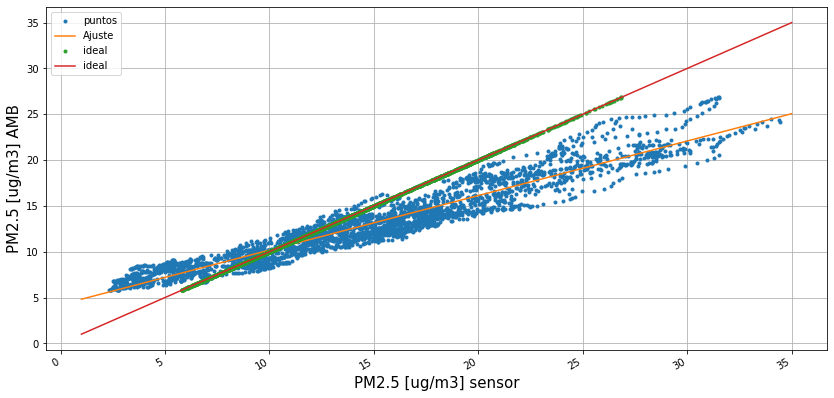

In [31]:
x = np.linspace(1,35,len(data["sensor"]))
plt.figure(figsize=(14,7))
plt.ylabel('PM2.5 [ug/m3] AMB', fontsize = 15)
plt.xlabel('PM2.5 [ug/m3] sensor', fontsize = 15)
#plt.plot(correccion,data["AMB"], '.', label = "puntos-modelo")
#plt.plot(x, x * popt1[0] + popt1[1], label = "Ajuste-modelo")

plt.plot(data["sensor"],data["AMB"], '.', label = "puntos")
plt.plot(x, x * popt[0] + popt[1], label = "Ajuste")

plt.plot(data["AMB"],data["AMB"], '.', label = "ideal")
plt.plot(x, x , label = "ideal")
plt.legend()
plt.gcf().autofmt_xdate()

plt.grid()

plt.show()

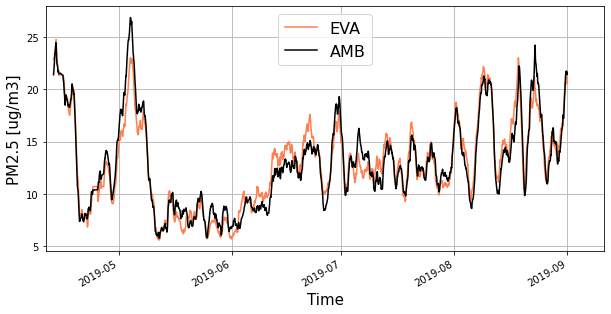

In [65]:
plt.figure(figsize=(10,5))
plt.gcf().autofmt_xdate()
plt.ylabel('PM2.5 [ug/m3]', fontsize = 15)
plt.xlabel('Time', fontsize = 15)
plt.gcf().autofmt_xdate()

#plt.plot(data["time"],data["sensor"], label = "sensor", color = "coral")
plt.plot(data["time"],correccion, color = 'coral', label = "EVA",lw =1.5)
plt.plot(data["time"],data["AMB"], label = "AMB",color = 'k' , lw = 1.5)
plt.xlim((datetime(2019,4,11),datetime(2019,9,11)))
plt.legend(loc = 9, fontsize = 16)
plt.grid()
plt.savefig('EVA_AMB.png', format='png', dpi=1200, orientation='landscape', bbox_inches='tight')
plt.show()

In [33]:
distancia_modelo = np.sqrt(np.sum((data["AMB"] - correccion) ** 2))
print (distancia_modelo)

69.34558880686593


error_1 = data["AMB"] - correcccion   
plt.plot(data["time"],error1)

plt.hist(error1)

In [34]:
error = ((data["AMB"] - data["sensor"] ) / data["AMB"] ) * 100
error2= ((data["AMB"] - correccion ) / data["AMB"] ) * 100
#plt.hist(data,error)



Text(0.5, 0, 'Error [%]')

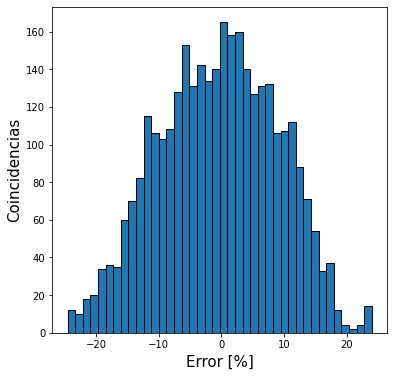

In [35]:
plt.figure(figsize=(6,6))
plt.hist(error2, bins = 40,alpha=1, edgecolor = 'black',  linewidth=1)
plt.ylabel('Coincidencias',fontsize = 15 )
plt.xlabel('Error [%]',fontsize = 15)

In [36]:
n = int(len(data) * 0.6)

v1 = data.iloc[:, 0]
v2 = data.iloc[:, 1]
v3 = data.iloc[:, 2]

popt, pcov = curve_fit(modelo,v3[:n],v2[:n])
correcccion = v3[:n] *popt[0] + popt[1]
prediccion = v3 *popt[0] + popt[1]


popt[0],popt[1]

(0.6169478148461978, 4.136742751819205)

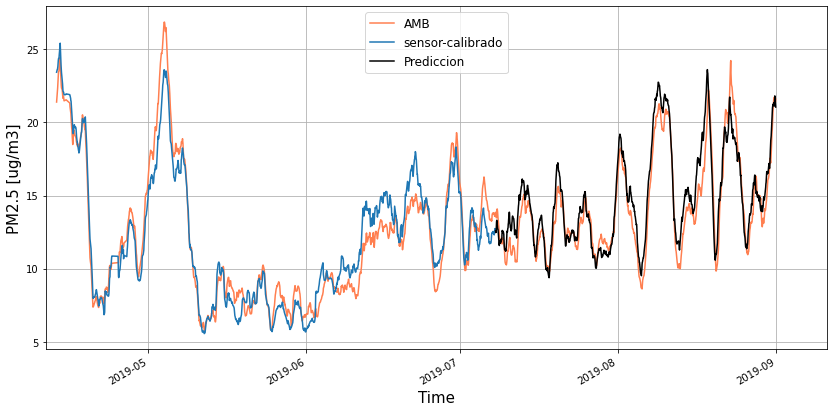

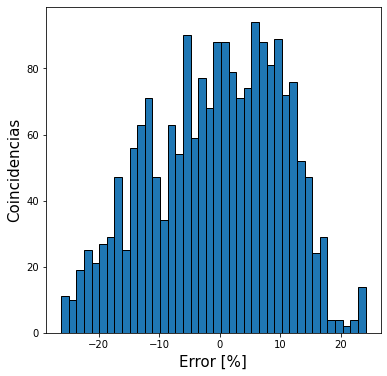

C:\Users\miguelta281\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\miguelta281\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


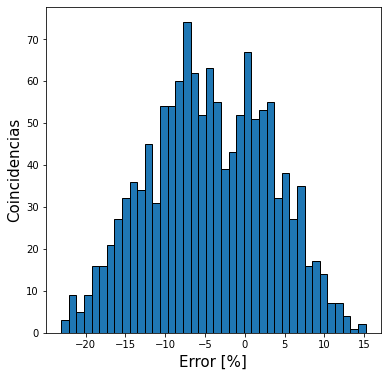

In [37]:
plt.figure(figsize=(14,7))
plt.ylabel('PM2.5 [ug/m3]', fontsize = 15)
plt.xlabel('Time', fontsize = 15)
plt.plot(v1,v2, label = "AMB", color = "coral")
#plt.plot(v1,v3, label = "sensor")
plt.plot(v1[:n],correcccion, label = "sensor-calibrado")
plt.plot(v1[n:],prediccion[n:], label = "Prediccion", color = "k")
plt.xlim((datetime(2019,4,11),datetime(2019,9,11)))
plt.legend(loc = 9, fontsize = 12)
plt.gcf().autofmt_xdate()
plt.grid()
plt.show()

error_c = ((v2[:n] - correcccion  ) /v2[:n])  * 100
error_p= ((v2[n:] - prediccion) / v2[n:] ) * 100



plt.figure(figsize=(6,6))
plt.hist(error_c, bins = 40,alpha=1, edgecolor = 'black',  linewidth=1)
plt.ylabel('Coincidencias',fontsize = 15 )
plt.xlabel('Error [%]',fontsize = 15)
plt.show()

plt.figure(figsize=(6,6))
plt.hist(error_p, bins = 40,alpha=1, edgecolor = 'black',  linewidth=1)
plt.ylabel('Coincidencias',fontsize = 15 )
plt.xlabel('Error [%]',fontsize = 15)
plt.show()



- Errores mejor forma de medirlo
- Porcentaje para generar el modelo, mi tolerancia la voy a dar apartir del total (usando toda la data para predecir) y si cuando calculo el nuevo error lo hago para todo o solo predicha 